In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

In [2]:
south_head = pd.read_csv("south_head.csv")
south_head

,,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,35-39 years,40-44 years,45-49 years,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85-89 years,90 years and over
0,Male,3,6,6,12,9,3,9,9,6,6,15,6,3,6,3,3,0,0,0
1,Female,6,0,3,6,3,6,3,9,3,6,9,6,9,3,3,3,0,0,0
2,Total,15,3,12,15,15,12,9,18,9,12,21,12,12,12,6,0,0,0,0


In [3]:
# Assumption, all bit-vectors are of the same size
num_bits = 5
num_vars = 19*2
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)

#Add contraints
numpy_data = south_head.to_numpy()[:,1:]

for i in range(19):
    g.add(ULE(x[i],numpy_data[0,i]+2))
    if(numpy_data[0,i]>0):
        g.add(ULE(numpy_data[0,i]-2,x[i]))

    g.add(ULE(x[i+19],numpy_data[1,i]+2))
    if(numpy_data[1,i]>0):
        g.add(ULE(numpy_data[1,i]-2,x[i+19]))

    g.add(ULE(x[i+19] + x[i], numpy_data[2,i]+2))
    if(numpy_data[2,i]>0):
        g.add(ULE(numpy_data[2,i]-2,x[i+19]+x[i]))

In [4]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 10000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fo

c Number of samples found until now:   2230
c Number of samples found until now:   2240
c Number of samples found until now:   2250
c Number of samples found until now:   2260
c Number of samples found until now:   2270
c Number of samples found until now:   2280
c Number of samples found until now:   2290
c Number of samples found until now:   2300
c Number of samples found until now:   2310
c Number of samples found until now:   2320
c Number of samples found until now:   2330
c Number of samples found until now:   2340
c Number of samples found until now:   2350
c Number of samples found until now:   2360
c Number of samples found until now:   2370
c Number of samples found until now:   2380
c Number of samples found until now:   2390
c Number of samples found until now:   2400
c Number of samples found until now:   2410
c Number of samples found until now:   2420
c Number of samples found until now:   2430
c Number of samples found until now:   2440
c Number of samples found until 

c Number of samples found until now:   4480
c Number of samples found until now:   4490
c Number of samples found until now:   4500
c Number of samples found until now:   4510
c Number of samples found until now:   4520
c Number of samples found until now:   4530
c Number of samples found until now:   4540
c Number of samples found until now:   4550
c Number of samples found until now:   4560
c Number of samples found until now:   4570
c Number of samples found until now:   4580
c Number of samples found until now:   4590
c Number of samples found until now:   4600
c Number of samples found until now:   4610
c Number of samples found until now:   4620
c Number of samples found until now:   4630
c Number of samples found until now:   4640
c Number of samples found until now:   4650
c Number of samples found until now:   4660
c Number of samples found until now:   4670
c Number of samples found until now:   4680
c Number of samples found until now:   4690
c Number of samples found until 

c Number of samples found until now:   6740
c Number of samples found until now:   6750
c Number of samples found until now:   6760
c Number of samples found until now:   6770
c Number of samples found until now:   6780
c Number of samples found until now:   6790
c Number of samples found until now:   6800
c Number of samples found until now:   6810
c Number of samples found until now:   6820
c Number of samples found until now:   6830
c Number of samples found until now:   6840
c Number of samples found until now:   6850
c Number of samples found until now:   6860
c Number of samples found until now:   6870
c Number of samples found until now:   6880
c Number of samples found until now:   6890
c Number of samples found until now:   6900
c Number of samples found until now:   6910
c Number of samples found until now:   6920
c Number of samples found until now:   6930
c Number of samples found until now:   6940
c Number of samples found until now:   6950
c Number of samples found until 

c Number of samples found until now:   9010
c Number of samples found until now:   9020
c Number of samples found until now:   9030
c Number of samples found until now:   9040
c Number of samples found until now:   9050
c Number of samples found until now:   9060
c Number of samples found until now:   9070
c Number of samples found until now:   9080
c Number of samples found until now:   9090
c Number of samples found until now:   9100
c Number of samples found until now:   9110
c Number of samples found until now:   9120
c Number of samples found until now:   9130
c Number of samples found until now:   9140
c Number of samples found until now:   9150
c Number of samples found until now:   9160
c Number of samples found until now:   9170
c Number of samples found until now:   9180
c Number of samples found until now:   9190
c Number of samples found until now:   9200
c Number of samples found until now:   9210
c Number of samples found until now:   9220
c Number of samples found until 

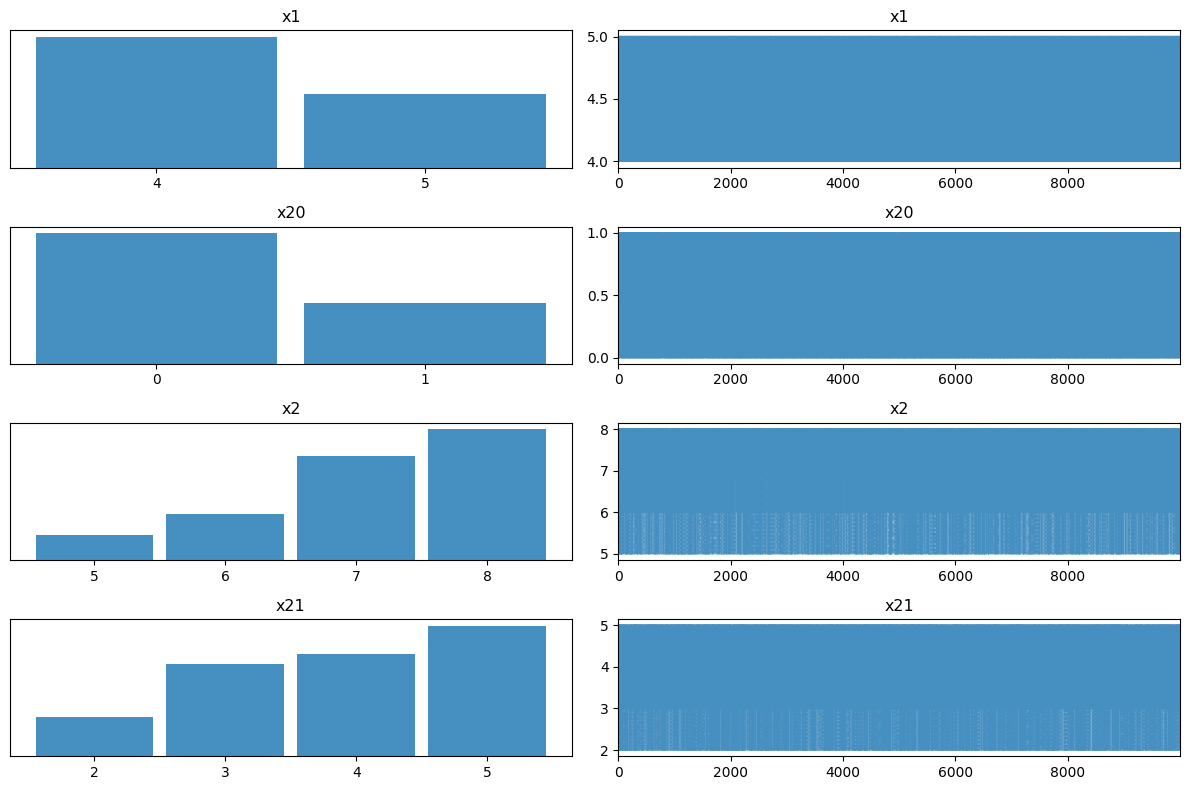

In [5]:
# Plot the posterior
az.plot_trace(trace, var_names=['x1', 'x20', 'x2', 'x21']);
plt.savefig('cmsgen_trace_plot_nz_db.png', dpi=150);

In [6]:
# Diagnostics
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,5.000,0.000,5.0,5.0,0.000,0.000,40000.0,40000.0,NaN
x1,4.359,0.480,4.0,5.0,0.002,0.002,39955.0,39955.0,1.0
x2,7.111,0.947,5.0,8.0,0.005,0.003,40804.0,39803.0,1.0
x3,11.007,0.973,10.0,13.0,0.005,0.003,39716.0,40000.0,1.0
x4,10.234,0.959,8.0,11.0,0.005,0.003,39678.0,39441.0,1.0
x5,3.886,1.019,2.0,5.0,0.005,0.004,40109.0,39394.0,1.0
x6,7.865,1.015,7.0,10.0,0.005,0.004,40031.0,39483.0,1.0
x7,8.910,1.429,7.0,11.0,0.007,0.005,40210.0,40000.0,1.0
x8,6.149,1.376,4.0,8.0,0.007,0.005,40398.0,39751.0,1.0
x9,6.114,1.384,4.0,8.0,0.007,0.005,39467.0,40000.0,1.0
